In [1]:
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
models = {
    # linear boundary
    'lda' : LinearDiscriminantAnalysis(),
    'log' : LogisticRegression(penalty = None, max_iter = 100), #increase max_iter can improve accuracy, at the cost of time
    'svc' : LinearSVC(dual = 'auto'),
    # Quadratic boundaries
    'qda' : QuadraticDiscriminantAnalysis(),
    'gnb' : GaussianNB(),
    # Ensemble models
    'dtc' : DecisionTreeClassifier(),
    'rfc' : RandomForestClassifier(),
    'etc' : ExtraTreesClassifier(),
    'xbg' : XGBClassifier()
}

In [3]:
# Data url: https://drive.google.com/file/d/1HR15iUnwowmYLiD9YS66QMhLWz2Zg2Ji/view?usp=drive_link
vec = pd.read_csv('../data/vectorized_data.csv')
vecFlat = pd.DataFrame(vec['output']).astype('int8') + 1 # XBG only works for y = [0, 1, 2]
vecFlat['weight'] = vec['weight'].astype('float32')
cols = vec.columns[:-2]
for col in cols:
    colDim = len(vec.iloc[0][col][1:-1].split(', '))
    colSplits = [col+str(i) for i in range(colDim)]
    vecFlat[colSplits] = vec[col].str[1:-1].str.split(', ', expand=True).astype('float32')
vecFlat.sample(5)

,output,weight,weather0,weather1,weather2,weather3,field0,field1,field2,field3,...,p2d44,p2d45,p2d46,p2d47,p2d48,p2d49,p2d50,p2d51,p2d52,p2d53
298,2,2.53875,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
93827,0,2.35750,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.02,0.02,0.02,0.02,0.02,0.02,100.0,0.0,0.0,0.0
44595,2,1.72375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
78846,2,1.67875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.02,0.02,0.02,0.02,0.02,0.02,100.0,0.0,0.0,0.0
57799,0,2.09500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.02,0.02,0.02,0.02,0.02,0.02,100.0,0.0,0.0,0.0


In [4]:
vf_train, vf_test = train_test_split(vecFlat, shuffle=True, random_state=1025, test_size=.2)
features = vecFlat.columns[1:]
target = vecFlat.columns[0]

In [5]:
accs = {}
for name, model in models.items():
    t0 = time()
    model.fit(vf_train[features],vf_train[target])
    accs[name] = accuracy_score(vf_test[target], model.predict(vf_test[features]))
    print(name,'takes',time()-t0,'seconds to fit, with accuracy',accs[name])

lda takes 2.940744638442993 seconds to fit, with accuracy 0.6723319170207448
log takes 8.22295093536377 seconds to fit, with accuracy 0.6567358160459885
svc takes 79.367746591568 seconds to fit, with accuracy 0.6715321169707573
qda takes 2.9653587341308594 seconds to fit, with accuracy 0.6161959510122469
gnb takes 1.0385112762451172 seconds to fit, with accuracy 0.5795051237190703
dtc takes 13.22167706489563 seconds to fit, with accuracy 0.6739315171207199
rfc takes 56.8536581993103 seconds to fit, with accuracy 0.765308672831792
etc takes 98.94482922554016 seconds to fit, with accuracy 0.7751062234441389
xbg takes 9.541370153427124 seconds to fit, with accuracy 0.7150212446888278


In [6]:
nexps = range(10)
knnAccs = np.zeros(10)
for nexp in nexps:
    t0 = time()
    n = 2**nexp
    knn = Pipeline([('scale', StandardScaler()),('knn', KNeighborsClassifier(n))])
    knn.fit(vf_train[features],vf_train.output.values)
    pred = knn.predict(vf_test[features])
    knnAccs[nexp] = accuracy_score(vf_test.output.values, pred)
    print(n,'neighbors take',time()-t0,'seconds to fit, with accuracy',knnAccs[nexp])

1 neighbors take 31.975131511688232 seconds to fit, with accuracy 0.7857035741064734
2 neighbors take 20.462826013565063 seconds to fit, with accuracy 0.7114721319670082
4 neighbors take 23.725067377090454 seconds to fit, with accuracy 0.691077230692327
8 neighbors take 23.321860551834106 seconds to fit, with accuracy 0.6611347163209198
16 neighbors take 25.815425157546997 seconds to fit, with accuracy 0.6459385153711572
32 neighbors take 22.188474893569946 seconds to fit, with accuracy 0.6293926518370407
64 neighbors take 22.598697662353516 seconds to fit, with accuracy 0.6236440889777556
128 neighbors take 23.699862718582153 seconds to fit, with accuracy 0.6196950762309422
256 neighbors take 23.51846981048584 seconds to fit, with accuracy 0.6204948762809298
512 neighbors take 25.29228115081787 seconds to fit, with accuracy 0.6239940014996251


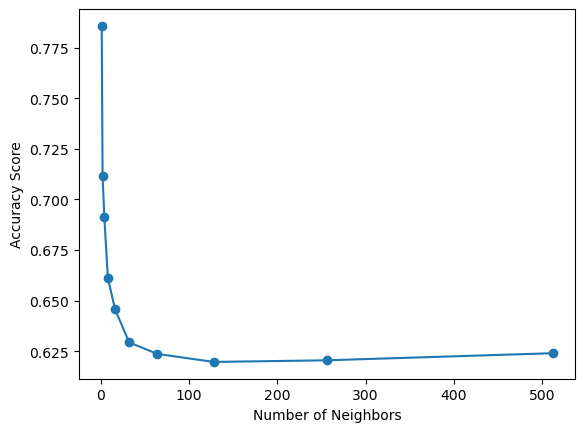

In [7]:
plt.plot(2**np.array(range(10)), knnAccs, '-o')
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy Score")
#plt.xscale('log')
plt.show()